In [24]:
import os
import sys
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
sys.path.append(os.getcwd()) 
import torch

from flower.task import Net, train
import torch
# import dataloader
from torch.utils.data import DataLoader
from lib.dataset_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lib.physionet import PhysioNet, variable_time_collate_fn, get_data_min_max
from sklearn import model_selection
from torch.utils.data import DataLoader
from lib import utils
from lib.dataset_utils import store_dataset_physionet
import matplotlib.pyplot as plt
from lib.plot import plot_trajectories

path_prefix = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data"
prefix = "physionet"
batch_size = 64
classif = False
noise_weight = 0.1
max_t_extrap = 5
n_total_tp = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amp_start = 1.0
amp_end = 1.0 
freq_start =1.0
freq_end = freq_start
epochs = 5
batch_size = 3
sample_tp = 0.9
n_samples = 4
max_t_extrap = 50
lr_val = 0.01
cut_tp = None
extrap = None

from types import SimpleNamespace
args = SimpleNamespace()
args.sample_tp = 0
args.cut_tp = None
args.extrap = None


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# Load dataset
c0 = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/physionet_filtered/client_1_test.pt", weights_only=False)
c1 = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/physionet_filtered/client_1_test.pt", weights_only=False)
attr_names = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/physionet_filtered/attr_names.pt", weights_only=False)
attr_names_filtered = attr_names

# load model weights 
model = Net()
w_cen = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/results_physionet_filtered/physionet_filtered/centralized_training/100_epochs/lr_0.001-batchsize_64_clipping_False_lrdecay_1.0/model.pth",  map_location=torch.device('cpu'), weights_only=True)
w_local = torch.load("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/results_physionet_filtered/physionet_filtered/local_training/client_0/100_epochs/100_epochs/lr_0.001-batchsize_64_clipping_False_lrdecay_1.0/model.pth",  map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(w_cen)
#model.load_state_dict(w_local)

GRU unit: latent_dim 40, input_dim 24, n_units 500


<All keys matched successfully>

Getting data min and max devices:  cpu


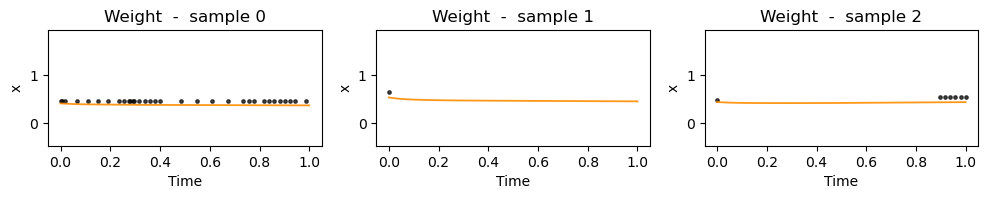

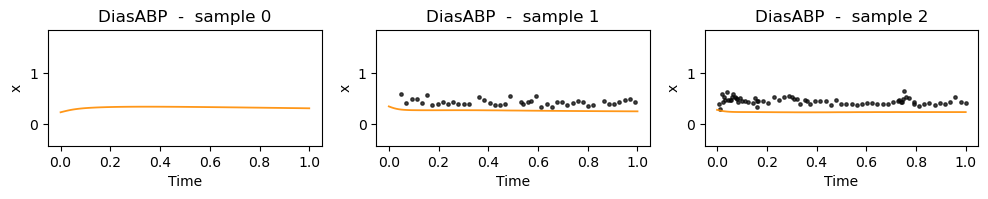

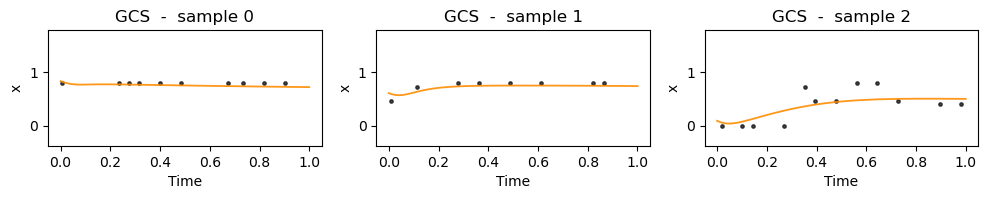

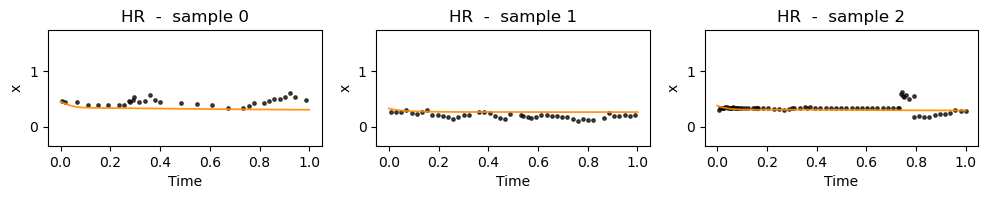

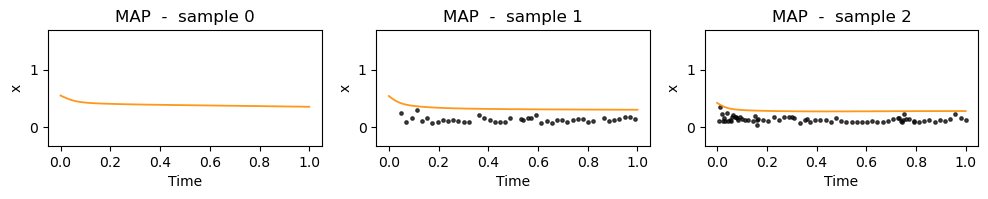

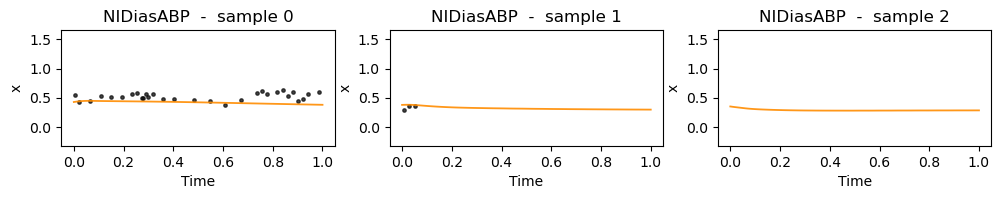

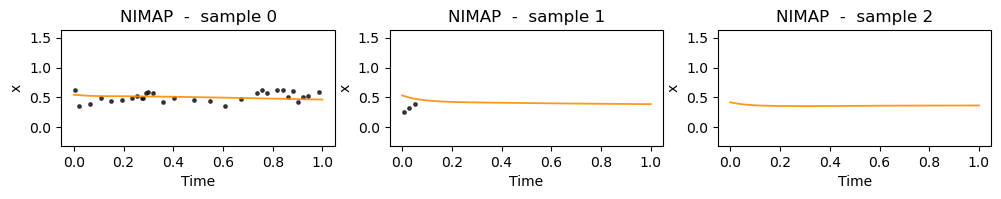

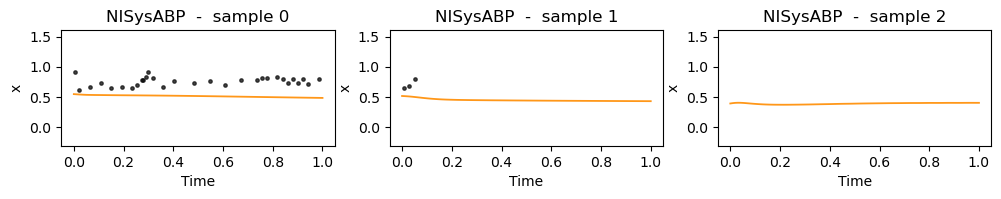

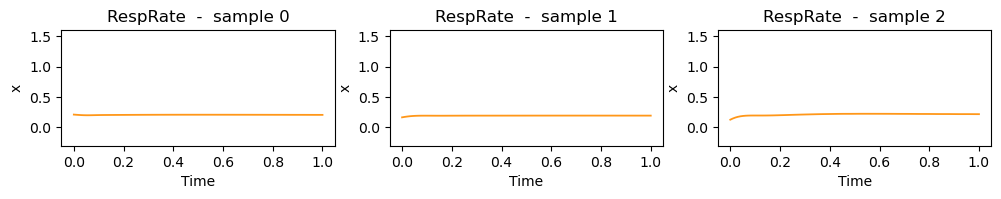

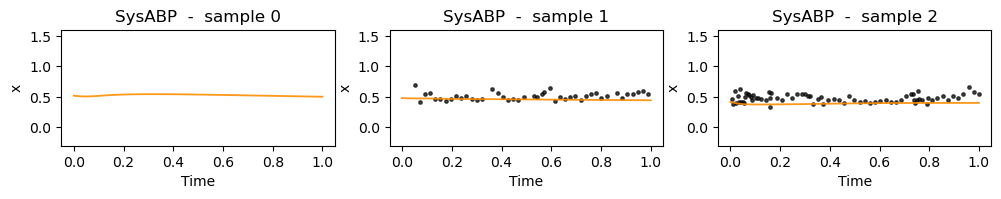

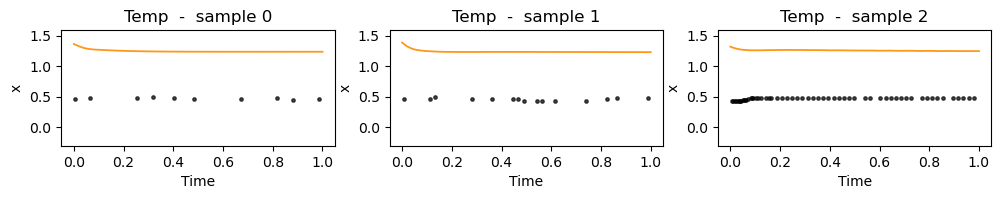

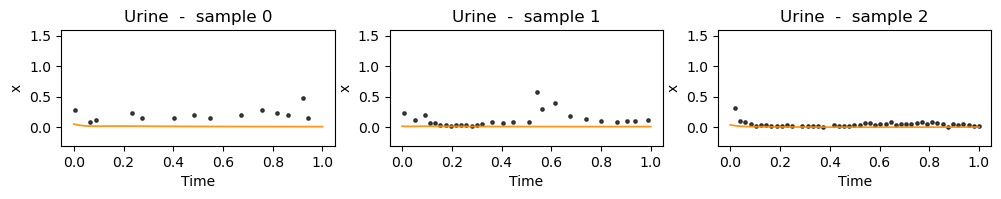

In [62]:
n_traj_to_show = 3
filtered_dataset = c0[10:40]
data_min, data_max = get_data_min_max(filtered_dataset)
testloader = DataLoader(filtered_dataset, batch_size= batch_size, shuffle=False,
    collate_fn= lambda batch: variable_time_collate_fn(batch, args, "cpu", data_type = "test",
        data_min = data_min, data_max = data_max))

testloader = utils.inf_generator(testloader)
test_dict = utils.get_next_batch(testloader)

# prepare dictionary in the format needed for prediction and plotting
data =  test_dict["data_to_predict"]
time_steps = test_dict["tp_to_predict"]
mask = test_dict["mask_predicted_data"]

observed_data =  test_dict["observed_data"]
observed_time_steps = test_dict["observed_tp"]
observed_mask = test_dict["observed_mask"]


time_steps_to_predict = time_steps
time_steps_to_predict = utils.linspace_vector(time_steps[0], time_steps[-1], 100).to(device)

with torch.no_grad():

    # Here use the model to obtain the predictions
    reconstructions, info = model.get_reconstruction(time_steps_to_predict, 
        observed_data, observed_time_steps, mask = observed_mask, n_traj_samples = 10)

    # plot only 10 trajectories
    data_for_plotting = observed_data[:n_traj_to_show]
    mask_for_plotting = observed_mask[:n_traj_to_show]

    data_full = data[:n_traj_to_show]

    reconstructions_for_plotting = reconstructions.mean(dim=0)[:n_traj_to_show]
    reconstr_std = reconstructions.std(dim=0)[:n_traj_to_show]

    for dim_to_show in range(attr_names_filtered.shape[0]):
        name = attr_names_filtered[dim_to_show]
        ax_traj = []
        fig, ax_traj = plt.subplots(1, n_traj_to_show)
        fig.set_size_inches(12, 1.5)
        max_y = max(
            data_for_plotting[:,:,dim_to_show].cpu().numpy().max(),
            reconstructions[:,:,dim_to_show].cpu().numpy().max())
        min_y = min(
            data_for_plotting[:,:,dim_to_show].cpu().numpy().min(),
            reconstructions[:,:,dim_to_show].cpu().numpy().min())
        
        cmap = plt.colormaps['Set1']
        for traj_id in range(n_traj_to_show):

            # Plot observations
            plot_trajectories(ax_traj[traj_id], 
                data_full[traj_id].unsqueeze(0), observed_time_steps, 
                mask = mask_for_plotting[traj_id].unsqueeze(0),
                min_y = min_y, max_y = max_y, #title="True trajectories", 
                marker = 'o', linestyle='', dim_to_show = dim_to_show, markersize= 2, alpha =0.9,
                color = "grey")
                    # Plot observations
            plot_trajectories(ax_traj[traj_id], 
                data_for_plotting[traj_id].unsqueeze(0), observed_time_steps, 
                mask = mask_for_plotting[traj_id].unsqueeze(0),
                min_y = min_y, max_y = max_y, #title="True trajectories", 
                marker = 'o', linestyle='', dim_to_show = dim_to_show, add_to_plot= True, markersize= 2.5, alpha =0.5,
                color = "black")
            
            # Plot reconstructions
            plot_trajectories(ax_traj[traj_id],
                reconstructions_for_plotting[traj_id].unsqueeze(0), time_steps_to_predict, 
                min_y = min_y, max_y = max_y, title="{}  -  sample {}".format(name, traj_id), dim_to_show = dim_to_show,
                add_to_plot = True, marker = '', color =  "darkorange", linewidth = 1.3, linestyle='-', alpha = 0.9)
            ax_traj[traj_id].set_ylim(min_y - 0.3, max_y+ 0.3)
    # print(min_y)
    
plt.show()

#### things to check 

- missingness distribution 
- how predictions are doing

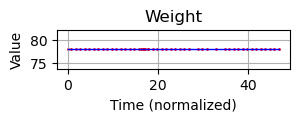

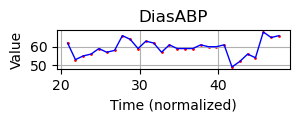

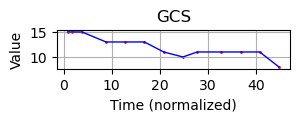

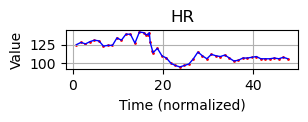

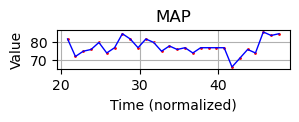

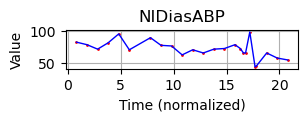

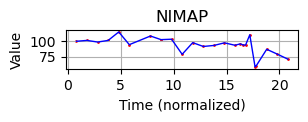

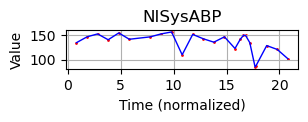

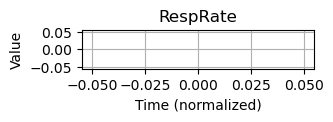

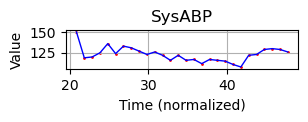

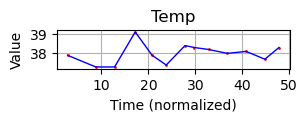

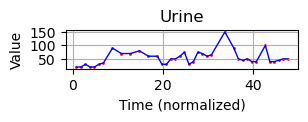

In [128]:

element = c0[3]
time_steps = element[1]
data = element[2]
mask = element[3]
attribute_filtered_idx_features = len(attr_names_filtered)
features =  attribute_filtered_idx_features
for i in range(features):
    feature_name = attr_names[i]
    plt.figure(figsize=(3, 0.5))
    # make a scatter plot
    plt.scatter(time_steps[mask[:, i] == 1], data[mask[:, i] == 1, i], color='red', s=1, label='Observed')
    # make a line plot for the whole time series but not plottting the zeros 
    plot_data = data[:, i][mask[:, i] == 1]
    plt.plot(time_steps[mask[:, i] == 1], plot_data, color='blue', linewidth=1, label='Full time series')
    plt.xlabel('Time (normalized)')
    plt.ylabel('Value')
    plt.title(f'{feature_name}')
    plt.grid()
    plt.show()

In [129]:
#################################################################
# Load data
################################################################
train_data_0 = torch.load(f"{path_prefix}/{prefix}/client_0_train.pt")
train_data_1 = torch.load(f"{path_prefix}/{prefix}/client_1_train.pt")
# now they are the same so i can use one
data_min = torch.load(f"{path_prefix}/{prefix}/client_0_data_min.pt")
data_max = torch.load(f"{path_prefix}/{prefix}/client_0_data_max.pt")
attr_names = torch.load(f"{path_prefix}/{prefix}/attr_names.pt")

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_75873/1000482328.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data_0 = torch.load(f"{path_prefix}/{pr

KeyboardInterrupt: 

In [ ]:
attribute_filtered_idx
# convert to scalar


tensor([])

array(['Weight', 'DiasABP', 'GCS', 'HR', 'MAP', 'NIDiasABP', 'NIMAP',
       'NISysABP', 'RespRate', 'SysABP', 'Temp', 'Urine'], dtype='<U11')

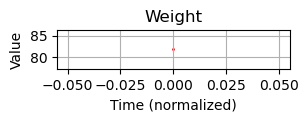

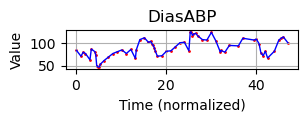

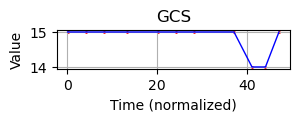

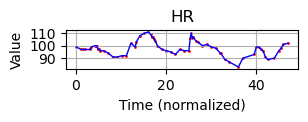

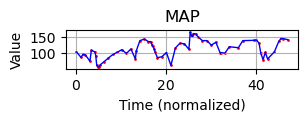

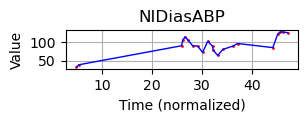

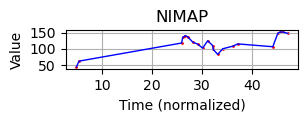

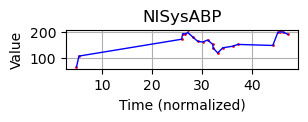

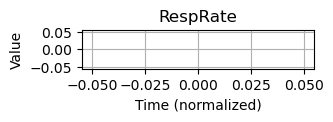

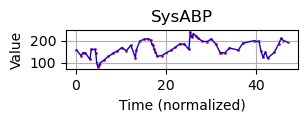

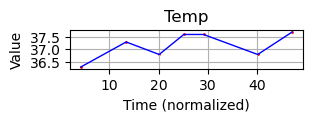

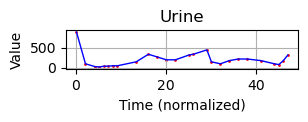

In [ ]:
#################################################################
# Play with visualization
################################################################

element = train_data_0[2]
time_steps = element[1]
data = element[2]
mask = element[3]
attribute_filtered_idx_features = np.where(attribute_filtered_idx)[0]
features =  attribute_filtered_idx_features
for i in features:
    feature_name = attr_names[i]
    plt.figure(figsize=(3, 0.5))
    # make a scatter plot
    plt.scatter(time_steps[mask[:, i] == 1], data[mask[:, i] == 1, i], color='red', s=1, label='Observed')
    # make a line plot for the whole time series but not plottting the zeros 
    plot_data = data[:, i][mask[:, i] == 1]
    plt.plot(time_steps[mask[:, i] == 1], plot_data, color='blue', linewidth=1, label='Full time series')
    plt.xlabel('Time (normalized)')
    plt.ylabel('Value')
    plt.title(f'{feature_name}')
    plt.grid()
    plt.show()